<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/004_B-Dataset_Assembler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loop Closure Dataset Assembly: Multi-Modal Feature Integration
## Phase 1.6: Training Dataset Assembly from Exported Parquet Files

**Version:** 1.0  
**Pipeline Phase:** Feature Extraction → Dataset Generation → **[THIS NOTEBOOK]** → Fusion MLP Training → Deployment  
**Target Hardware:** Waveshare Jetbot AI Pro Kit (Jetson Nano)  
**SLAM System:** Google Cartographer (2D)  
**Training Platform:** Vertex AI

---

---

# DATASET ASSEMBLY

---



## 1. NOTEBOOK DOCUMENTATION

---

### 1.1 What This Notebook Does

this notebook performs the final assembly of the loop closure detection dataset by combining multi-modal features with labeled node pairs to create ready-to-train datasets. This section bridges the gap between the intermediate parquet files generated in Section 8 and the final machine learning training pipeline.

**Core Operations:**

**Data Loading & Validation:**
- Loads all five parquet files from Section 8 (trajectory, all_pairs, time_alignments, labeled_pairs, export_metadata)
- Loads extracted features from features.h5 (camera: 1280D MobileNetV2, LiDAR: 256D 1D-CNN)
- Validates referential integrity across all data files
- Checks feature dimension consistency against metadata
- Verifies temporal alignment coverage and quality

**Data Assembly Flow:**

1. **Load labeled_pairs.parquet** → Extract (node_pair_id, label, pair_type) for all training pairs

2. **Lookup in all_pairs.parquet[node_pair_id]** → Retrieve (node1_id, node2_id, distance, time_diff) for each pair

3. **Lookup in time_alignments.parquet** → Query by node1_id and node2_id to obtain:
   - camera_feat_id and lidar_feat_id for node1
   - camera_feat_id and lidar_feat_id for node2

4. **Load features from features.h5** → Extract multi-modal features:
   - camera_features[camera_feat_id] → 1280D vector (L2-normalized MobileNetV2 embeddings)
   - lidar_features[lidar_feat_id] → 256D vector (L2-normalized 1D-CNN descriptors)
   - Concatenate into pairwise feature: [camera1 + lidar1 + camera2 + lidar2] → 3072D vector

5. **Create training examples** → Assemble final dataset with:
   - Pairwise features: 3072D concatenated multi-modal descriptor
   - Binary labels: 1 (loop closure) or 0 (no loop closure)
   - Metadata: node IDs, distances, time differences, pair types

**Dataset Splitting:**
- Performs stratified train/validation/test split maintaining label balance
- Default split ratios: 70% train, 15% validation, 15% test
- Ensures all three pair types (positive, easy negative, hard negative) are represented in each split
- Validates class balance and feature statistics across splits

**Quality Assurance:**
- Computes feature statistics (mean, variance, low-variance feature detection)
- Generates diagnostic visualizations (trajectory plots, distance distributions, PCA projections)
- Creates comprehensive text reports with dataset statistics
- Validates no data leakage between splits

**Final Output:**
- Exports assembled dataset as pickle file (loop_closure_dataset.pkl)
- Saves diagnostic plots (dataset_diagnostics.png)
- Generates human-readable summary report (dataset_generation_report.txt)
- Packages metadata including configuration, dimensions, and statistics

**Purpose in Pipeline:**
This section transforms raw parquet files and feature vectors into a structured, validated, and split dataset ready for supervised learning. The output pkl file can be directly consumed by the Fusion MLP training pipeline without additional preprocessing. All feature vectors are pre-normalized, temporally aligned, and labeled with high-confidence ground truth from Cartographer's SLAM graph.

### 1.2 Expected Input Files

this notebook requires six input files generated from previous pipeline stages. All files must be present and properly formatted, as missing or corrupted files will cause the assembly process to fail.

---

**Required Input Directory Structure:**

```
session_YYYYMMDD_HHMMSS/
├── features/
│   └── features.h5               ← INPUT: Multi-modal feature vectors
└── dataset/
    ├── trajectory.parquet        ← INPUT: SLAM trajectory nodes
    ├── all_pairs.parquet         ← INPUT: Pairwise node relationships
    ├── time_alignments.parquet   ← INPUT: Feature temporal alignments
    ├── labeled_pairs.parquet     ← INPUT: Labeled training pairs
    └── export_metadata.json      ← INPUT: Dataset generation metadata
```

---

#### **1. features.h5** (Feature Extraction Output)

**Location:** `features/features.h5`  
**Source:** Feature extraction pipeline (preceding notebook)  
**Format:** HDF5 hierarchical data structure

**Contents:**

**Camera Features Group (`/camera/`):**
- `features`: [N_cam, 1280] float32 array - MobileNetV2 embeddings, L2-normalized
- `timestamps_sec`: [N_cam] int64 array - ROS timestamp seconds
- `timestamps_nsec`: [N_cam] int32 array - ROS timestamp nanoseconds
- `filenames`: [N_cam] string array - Source image filenames for traceability

**LiDAR Features Group (`/lidar/`):**
- `features`: [N_lid, 256] float32 array - 1D-CNN descriptors, L2-normalized
- `timestamps_sec`: [N_lid] int64 array - ROS timestamp seconds
- `timestamps_nsec`: [N_lid] int32 array - ROS timestamp nanoseconds
- `filenames`: [N_lid] string array - Source scan filenames for traceability

**Critical Properties:**
- All feature vectors are L2-normalized (unit length)
- Camera and LiDAR feature counts may differ due to independent sensor rates
- Timestamps are high-precision (nanosecond resolution) ROS format
- Feature dimensions must match metadata specifications (1280 for camera, 256 for LiDAR)

---

#### **2. trajectory.parquet** (SLAM Trajectory Nodes)

**Location:** `dataset/trajectory.parquet`  
**Source:** Section 8 - Pbstream extraction  
**Format:** Apache Parquet columnar format

**Schema:**

| Column | Type | Description | Example |
|--------|------|-------------|----------|
| `node_id` | int64 | Unique trajectory node identifier (PRIMARY KEY) | 42 |
| `timestamp_sec` | int64 | ROS timestamp seconds | 1634567890 |
| `timestamp_nsec` | int32 | ROS timestamp nanoseconds | 123456789 |
| `x_m` | float64 | X position in meters (global frame) | 2.456 |
| `y_m` | float64 | Y position in meters (global frame) | -1.234 |
| `z_m` | float64 | Z position in meters (global frame) | 0.003 |
| `qx` | float64 | Quaternion X component | 0.001 |
| `qy` | float64 | Quaternion Y component | 0.002 |
| `qz` | float64 | Quaternion Z component | 0.707 |
| `qw` | float64 | Quaternion W component | 0.707 |

**Properties:**
- One row per SLAM trajectory node extracted from Cartographer pbstream
- `node_id` serves as primary key referenced by other tables
- Full 6-DOF pose representation (position + orientation quaternion)
- Timestamps enable temporal alignment with sensor features
- Typical size: 100-500 KB for sessions of 5-30 minutes

---

#### **3. all_pairs.parquet** (Pairwise Node Relationships)

**Location:** `dataset/all_pairs.parquet`  
**Source:** Section 8 - Pairwise distance computation  
**Format:** Apache Parquet with indexed primary key

**Schema:**

| Column | Type | Description | Example |
|--------|------|-------------|----------|
| `node_pair_id` | int64 | Unique pair identifier (PRIMARY KEY, stored as index) | 1234567 |
| `node1_id` | int64 | First node ID (FOREIGN KEY → trajectory.node_id) | 42 |
| `node2_id` | int64 | Second node ID (FOREIGN KEY → trajectory.node_id) | 156 |
| `distance` | float64 | Euclidean distance between nodes in meters | 1.23 |
| `time_diff` | float64 | Time difference between nodes in seconds | 45.67 |

**Properties:**
- Contains all possible node pairs (combinatorial: N*(N-1)/2 pairs)
- `node_pair_id` is stored as dataframe index (accessible via .loc[])
- Distance computed from 3D Euclidean distance: sqrt((x1-x2)² + (y1-y2)² + (z1-z2)²)
- Time difference computed from ROS timestamps with nanosecond precision
- Both node1_id and node2_id reference trajectory.parquet node_id column
- Largest file in dataset: scales O(N²) with trajectory length
- Typical size: 10-500 MB depending on session duration

---

#### **4. time_alignments.parquet** (Feature Temporal Alignments)

**Location:** `dataset/time_alignments.parquet`  
**Source:** Section 8 - KD-tree temporal alignment  
**Format:** Apache Parquet

**Schema:**

| Column | Type | Description | Example |
|--------|------|-------------|----------|
| `node_id` | int64 | Trajectory node ID (PRIMARY KEY, FOREIGN KEY → trajectory.node_id) | 42 |
| `camera_feat_id` | float64 | Camera feature index in features.h5 (NaN if no match) | 15.0 or NaN |
| `lidar_feat_id` | float64 | LiDAR feature index in features.h5 (NaN if no match) | 23.0 or NaN |
| `camera_time_offset` | float64 | Time offset to camera feature in seconds | 0.234 |
| `lidar_time_offset` | float64 | Time offset to LiDAR feature in seconds | -0.156 |

**Properties:**
- One row per trajectory node (matches trajectory.parquet row count)
- `node_id` is primary key and foreign key to trajectory.parquet
- Feature IDs reference array indices in features.h5 datasets
- NaN values indicate no feature found within temporal alignment threshold (±700ms default)
- Time offsets indicate alignment quality (smaller absolute values = better temporal sync)
- Only nodes with both non-NaN camera_feat_id and lidar_feat_id can be used in final dataset
- Typical size: 50-200 KB

---

#### **5. labeled_pairs.parquet** (Labeled Training Pairs)

**Location:** `dataset/labeled_pairs.parquet`  
**Source:** Section 8 - Pair generation and labeling  
**Format:** Apache Parquet

**Schema:**

| Column | Type | Description | Example |
|--------|------|-------------|----------|
| `node_pair_id` | int64 | Pair identifier (FOREIGN KEY → all_pairs.parquet index) | 1234567 |
| `label` | int8 | Binary label: 1=loop closure, 0=no loop closure | 1 |
| `pair_type` | string | Pair generation strategy | 'positive' |

**Pair Types:**
- **'positive'**: True loop closures from Cartographer INTER_SUBMAP constraints
- **'easy_negative'**: Spatially distant pairs (>5m distance, >5s temporal gap)
- **'hard_negative'**: Perceptually similar but spatially distant pairs (high feature similarity, >3m distance)

**Properties:**
- Contains only validated pairs with complete feature alignments (no NaN in time_alignments)
- `node_pair_id` references the index of all_pairs.parquet to retrieve node1_id, node2_id, distance, time_diff
- Every node_pair_id in this file MUST exist in all_pairs.parquet
- Both nodes in each pair MUST have non-NaN feature IDs in time_alignments.parquet
- Label distribution typically: ~30% positive, ~35% easy negative, ~35% hard negative
- Typical size: 50-500 KB depending on trajectory complexity

---

#### **6. export_metadata.json** (Dataset Generation Metadata)

**Location:** `dataset/export_metadata.json`  
**Source:** Section 8 - Configuration and statistics export  
**Format:** JSON (human-readable text)

**Contents:**

**Configuration Parameters:**
- Temporal alignment threshold (MAX_TIME_OFFSET)
- Distance thresholds for positive/negative pair generation
- Similarity thresholds for hard negative mining
- Angular distance constraints
- Random seed for reproducibility

**Statistics:**
- Total trajectory nodes and valid alignments
- INTER_SUBMAP constraint counts
- Positive/negative pair counts by type
- Feature dimension specifications
- Alignment coverage percentages

**Session Information:**
- Session ID and creation timestamp
- Source file paths
- Processing duration

**Properties:**
- Used for validation and consistency checking in this notebook
- Enables reproducibility of dataset generation
- Documents configuration for experiment tracking
- Typical size: 5-10 KB

---

**File Dependencies & Integrity Requirements:**

**Mandatory Files:**
All six files must be present. Missing any file causes this notebook to fail with FileNotFoundError.

**Referential Integrity:**
- Every `node_pair_id` in labeled_pairs.parquet MUST exist in all_pairs.parquet index
- Every `node1_id` and `node2_id` in all_pairs.parquet MUST exist in trajectory.parquet
- Every `node_id` in labeled pairs (via all_pairs lookup) MUST have non-NaN camera_feat_id and lidar_feat_id in time_alignments.parquet
- Every camera_feat_id and lidar_feat_id MUST be valid indices (0 to N-1) in features.h5 arrays

**Data Quality Requirements:**
- Feature vectors in features.h5 must be L2-normalized (unit length)
- Feature dimensions must match metadata (camera: 1280D, LiDAR: 256D)
- No duplicate node_ids in trajectory.parquet
- No duplicate node_pair_ids in labeled_pairs.parquet
- Time offsets in time_alignments.parquet must be within configured threshold

**Memory Considerations:**
- all_pairs.parquet can be very large (10-500 MB) due to O(N²) scaling
- features.h5 contains full resolution feature vectors (camera: ~5 MB per 1000 frames, LiDAR: ~1 MB per 1000 scans)
- this notebook loads data incrementally using pandas and h5py for memory efficiency
- Peak memory usage proportional to number of labeled pairs × feature dimension (3072D)

**File Portability:**
- All parquet files use standard Apache Parquet format (readable by pandas, PyArrow, Spark, DuckDB)
- HDF5 features file follows standard HDF5 specification (readable by h5py, PyTables, MATLAB, R)
- JSON metadata is standard and human-readable
- Files can be archived, versioned, or transferred independently while maintaining relationships

---

### 1.3 Dataset/Dictionary Documentation

This section describes the internal structure of the dataset dictionary and its components.

---

#### 1.3.1 Top-Level Dictionary Structure

The dataset is organized as a Python dictionary with four top-level keys:

```
dataset_package = {
    'train': [list of training examples],
    'val': [list of validation examples],
    'test': [list of test examples],
    'metadata': {dictionary of dataset metadata}
}
```

---

#### 1.3.2 Metadata Dictionary Structure

The `'metadata'` key contains a nested dictionary with comprehensive information about dataset generation, configuration, and statistics.

**Top-Level Metadata Fields:**

| Field | Type | Description | Example |
|-------|------|-------------|----------|
| `session_id` | str | Unique session identifier | 'session_20241113_143052' |
| `creation_date` | str | Dataset creation timestamp (ISO format) | '2024-11-13' |
| `num_trajectory_nodes` | int | Total SLAM trajectory nodes in session | 487 |
| `num_valid_nodes` | int | Nodes with complete feature alignments | 423 |
| `num_constraints` | int | INTER_SUBMAP constraints (ground truth loops) | 78 |
| `feature_dim` | int | Concatenated feature vector dimension | 3072 |
| `random_seed` | int | Random seed for reproducible splitting | 42 |
| `config` | dict | Nested dictionary of generation parameters | (see below) |

**Session Information:**
- `session_id`: Unique identifier linking dataset to source data
- `creation_date`: Timestamp of dataset assembly completion
- Enables traceability back to original sensor data and SLAM outputs

**Node Statistics:**
- `num_trajectory_nodes`: Total nodes extracted from Cartographer pbstream
- `num_valid_nodes`: Nodes with both camera and LiDAR features within temporal alignment threshold
- Alignment coverage = (num_valid_nodes / num_trajectory_nodes) × 100%
- Only valid nodes can participate in labeled pairs

**Ground Truth Statistics:**
- `num_constraints`: Number of INTER_SUBMAP constraints from Cartographer
- These constraints provide high-confidence positive labels
- Represent locations where SLAM successfully detected loop closures via scan matching

**Feature Dimension:**
- `feature_dim`: Always 3072 for current pipeline configuration
- Composition: (1280 camera + 256 lidar) × 2 nodes = 3072 total
- Used for validation and consistency checking

**Reproducibility:**
- `random_seed`: Seed used for stratified train/val/test splitting
- Enables exact reproduction of dataset splits
- Critical for experiment reproducibility and fair model comparison

---

#### 1.3.3 Configuration Parameters

The `'config'` sub-dictionary within metadata contains all threshold and constraint parameters used during dataset generation.

**Configuration Fields:**

| Parameter | Type | Description | Typical Value |
|-----------|------|-------------|---------------|
| `max_time_offset` | float | Maximum temporal alignment offset (seconds) | 0.7 |
| `positive_distance_threshold` | float | Maximum spatial distance for positive pairs (meters) | 2.0 |
| `easy_negative_min_distance` | float | Minimum distance for easy negative pairs (meters) | 5.0 |
| `hard_negative_min_distance` | float | Minimum distance for hard negative pairs (meters) | 3.0 |
| `hard_negative_similarity_threshold` | float | Minimum cosine similarity for hard negatives | 0.7 |
| `max_constraint_residual` | float | Maximum residual error for INTER_SUBMAP constraints | 0.5 |
| `max_angular_distance` | float | Maximum angular distance for positive pairs (radians) | 0.785 (≈45°) |

**Parameter Descriptions:**

**Temporal Alignment:**
- `max_time_offset`: Maximum allowed time difference between feature timestamp and trajectory node timestamp
- Features must be captured within ±700ms of trajectory node to be considered aligned
- Balances temporal precision with sensor capture rates
- Tighter thresholds reduce alignment coverage but improve temporal accuracy

**Positive Pair Criteria:**
- `positive_distance_threshold`: Maximum Euclidean distance between node poses for a pair to be considered a loop closure
- INTER_SUBMAP constraints provide initial candidates, distance threshold filters false positives
- Typical value ~2m reflects Cartographer's loop closure detection range and localization accuracy
- Pairs exceeding this distance are rejected even if INTER_SUBMAP constraint exists

- `max_constraint_residual`: Maximum optimization residual error for accepted INTER_SUBMAP constraints
- Residual measures alignment quality after pose graph optimization
- Lower residuals indicate higher confidence loop closures
- Filters weak or ambiguous loop closure detections

- `max_angular_distance`: Maximum angular difference (yaw) between node orientations for positive pairs
- Ensures robot is facing similar direction when revisiting location
- Typical value ~45° allows moderate orientation variation
- Prevents matching locations approached from opposite directions

**Negative Pair Generation:**
- `easy_negative_min_distance`: Minimum spatial separation for easy negative pairs
- Easy negatives are spatially distant and perceptually dissimilar
- Typical value >5m ensures clear spatial separation
- Provides baseline discriminative signal for classifier training

- `hard_negative_min_distance`: Minimum spatial separation for hard negative pairs
- Hard negatives are perceptually similar but spatially distinct
- Typical value ~3-4m creates challenging examples near decision boundary
- Forces network to learn subtle discriminative features beyond surface similarity

- `hard_negative_similarity_threshold`: Minimum cosine similarity for hard negative candidate selection
- Computed from concatenated camera+lidar features
- Typical value ~0.7 identifies pairs with strong perceptual resemblance
- Higher thresholds select more difficult hard negatives

**Impact on Dataset Characteristics:**
- Stricter thresholds reduce dataset size but improve label quality
- Looser thresholds increase dataset size but may introduce label noise
- Configuration preserved in metadata enables analysis of threshold sensitivity
- Parameters can be tuned based on robot platform, environment complexity, and SLAM performance

---

## 2. ENVIRONMENT SETUP

In [1]:
# Install required packages
!pip install -q h5py scikit-learn matplotlib pandas pyarrow

print("✅ All packages installed successfully")

✅ All packages installed successfully


## 3. IMPORTS

In [2]:
# System and file I/O
import os
import sys
import pickle
import json
from pathlib import Path

# Numerical computing
import numpy as np
from sklearn.decomposition import PCA

# Data handling
import h5py
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm import tqdm

# Random state for reproducibility
import random

print("✅ All imports successful")
print(f"   NumPy version: {np.__version__}")
print(f"   Python version: {sys.version.split()[0]}")

✅ All imports successful
   NumPy version: 2.0.2
   Python version: 3.12.12


## 4. STORAGE MOUNT & SESSION CONFIGURATION

In [3]:
# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("🔵 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("🔵 Running in local environment")

# Mount Google Drive if in Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(f"\n🎲 Random seed set to: {RANDOM_SEED}")

🔵 Running in Google Colab
Mounted at /content/drive
✅ Google Drive mounted

🎲 Random seed set to: 42


## 5. WORKING FOLDER & PATH CONFIGURATION

In [4]:
# Configure session folder
SESSION_ID = 'session_20251022_155137'  # ← CHANGE THIS to your session folder name

if IN_COLAB:
    # Google Colab: Assume data is in Drive
    BASE_PATH = f'/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/{SESSION_ID}'
else:
    # Local: Use current directory or specify path
    BASE_PATH = f'./{SESSION_ID}'  # Or specify full path: '/path/to/data/{SESSION_ID}'

# Change to working directory
os.chdir(BASE_PATH)
print(f"\n📁 Working directory: {os.getcwd()}")
print(f"   Session ID: {SESSION_ID}")

# Configure paths
FEATURES_DIR = 'features'
OUTPUT_DIR = 'dataset'
DATASET_FILE = os.path.join(OUTPUT_DIR, 'loop_closure_dataset.pkl')
DIAGNOSTICS_FILE = os.path.join(OUTPUT_DIR, 'dataset_diagnostics.png')
REPORT_FILE = os.path.join(OUTPUT_DIR, 'dataset_generation_report.txt')

print("\n📂 Path Configuration:")
print(f"  Features directory: {FEATURES_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Dataset file: {DATASET_FILE}")

# Verify output directory exists (should be created by Section 8)
if not os.path.exists(OUTPUT_DIR):
    raise FileNotFoundError(
        f"\n❌ Output directory not found: {OUTPUT_DIR}\n"
        f"   Please run Section 8 (OUTPUT) first to create exported files."
    )
print(f"\n✅ Output directory verified: {OUTPUT_DIR}")


📁 Working directory: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137
   Session ID: session_20251022_155137

📂 Path Configuration:
  Features directory: features
  Output directory: dataset
  Dataset file: dataset/loop_closure_dataset.pkl

✅ Output directory verified: dataset


## 6. LOAD DATA FROM DISK

**CRITICAL:** All data for this notebook onwards must be loaded from the exported files in Section 8.
This validates the export/import cycle and ensures dataset reproducibility.

In [5]:
print("\n" + "="*70)
print("LOADING DATA FROM DISK FOR DATASET ASSEMBLY")
print("="*70)

import os
import json
import pandas as pd
import h5py

# File paths
trajectory_file = os.path.join(OUTPUT_DIR, 'trajectory.parquet')
all_pairs_file = os.path.join(OUTPUT_DIR, 'all_pairs.parquet')
alignments_file = os.path.join(OUTPUT_DIR, 'time_alignments.parquet')
labels_file = os.path.join(OUTPUT_DIR, 'labeled_pairs.parquet')
metadata_file = os.path.join(OUTPUT_DIR, 'export_metadata.json')
features_file = os.path.join(FEATURES_DIR, 'features.h5')

# Validate all files exist
required_files = {
    'trajectory.parquet': trajectory_file,
    'all_pairs.parquet': all_pairs_file,
    'time_alignments.parquet': alignments_file,
    'labeled_pairs.parquet': labels_file,
    'export_metadata.json': metadata_file,
    'features.h5': features_file
}

print("\n🔍 Validating file existence...")
missing_files = []
for name, path in required_files.items():
    if os.path.exists(path):
        size = os.path.getsize(path)
        if size < 1024*1024:
            print(f"  ✓ {name}: {size/1024:.2f} KB")
        else:
            print(f"  ✓ {name}: {size/(1024*1024):.2f} MB")
    else:
        print(f"  ✗ {name}: MISSING")
        missing_files.append(name)

if missing_files:
    raise FileNotFoundError(
        f"\n❌ Missing required files: {missing_files}\n"
        f"   Please run Section 8 (OUTPUT) to export data before running this notebook."
    )

print("\n✅ All required files present")

# Load trajectory
print("\n📂 Loading trajectory...")
df_trajectory_loaded = pd.read_parquet(trajectory_file)
print(f"  Loaded {len(df_trajectory_loaded)} trajectory nodes")

# Load all pairs (with index)
print("\n📂 Loading all pairs...")
df_all_pairs_loaded = pd.read_parquet(all_pairs_file)
print(f"  Loaded {len(df_all_pairs_loaded)} pair records")

# Load time alignments
print("\n📂 Loading time alignments...")
time_alignments_loaded = pd.read_parquet(alignments_file)
print(f"  Loaded {len(time_alignments_loaded)} alignment records")

# Load labeled pairs
print("\n📂 Loading labeled pairs...")
labeled_pairs_loaded = pd.read_parquet(labels_file)
print(f"  Loaded {len(labeled_pairs_loaded)} labeled pairs")
print(f"    Positive: {(labeled_pairs_loaded['label'] == 1).sum()}")
print(f"    Negative: {(labeled_pairs_loaded['label'] == 0).sum()}")

# Load metadata
print("\n📂 Loading export metadata...")
with open(metadata_file, 'r') as f:
    export_metadata_loaded = json.load(f)
print(f"  Session: {export_metadata_loaded['session_info']['session_id']}")
print(f"  Feature dimensions: Camera={export_metadata_loaded['feature_dimensions']['camera_features']}, "
      f"LiDAR={export_metadata_loaded['feature_dimensions']['lidar_features']}")

# Extract configuration parameters from metadata
print("\n⚙️  Extracting configuration parameters from metadata...")
thresholds = export_metadata_loaded['thresholds']
MAX_TIME_OFFSET = thresholds['max_time_offset_ms']
POSITIVE_DISTANCE_THRESHOLD = thresholds['positive_distance_threshold_m']
POSITIVE_TIME_GAP = thresholds.get('positive_time_gap_s', 10.0)
EASY_NEGATIVE_MIN_DISTANCE = thresholds['easy_negative_min_distance_m']
HARD_NEGATIVE_MIN_DISTANCE = thresholds['hard_negative_min_distance_m']
HARD_NEGATIVE_SIMILARITY_THRESHOLD = thresholds['hard_negative_similarity_threshold']
MAX_CONSTRAINT_RESIDUAL = thresholds['max_constraint_residual']
MAX_ANGULAR_DISTANCE = thresholds['max_angular_distance_rad']

print(f"  MAX_TIME_OFFSET: {MAX_TIME_OFFSET}")
print(f"  POSITIVE_DISTANCE_THRESHOLD: {POSITIVE_DISTANCE_THRESHOLD}m")
print(f"  POSITIVE_TIME_GAP: {POSITIVE_TIME_GAP}s")
print(f"  EASY_NEGATIVE_MIN_DISTANCE: {EASY_NEGATIVE_MIN_DISTANCE}m")
print(f"  HARD_NEGATIVE_MIN_DISTANCE: {HARD_NEGATIVE_MIN_DISTANCE}m")
print(f"  HARD_NEGATIVE_SIMILARITY_THRESHOLD: {HARD_NEGATIVE_SIMILARITY_THRESHOLD}")
print(f"  MAX_CONSTRAINT_RESIDUAL: {MAX_CONSTRAINT_RESIDUAL}")
print(f"  MAX_ANGULAR_DISTANCE: {MAX_ANGULAR_DISTANCE} rad")

# Reconstruct complete_alignments and loop_closure_pairs from loaded data
print("\n🔄 Reconstructing derived variables from loaded data...")
# complete_alignments: nodes with both camera and lidar features (no NaN)
complete_alignments = time_alignments_loaded[
    time_alignments_loaded['camera_feat_id'].notna() &
    time_alignments_loaded['lidar_feat_id'].notna()
]
print(f"  complete_alignments: {len(complete_alignments)} nodes")

# loop_closure_pairs: positive pairs from labeled_pairs
loop_closure_pairs = labeled_pairs_loaded[labeled_pairs_loaded['label'] == 1]
print(f"  loop_closure_pairs: {len(loop_closure_pairs)} pairs")

# Load HDF5 features
print("\n📂 Loading HDF5 features...")
with h5py.File(features_file, 'r') as f:
    camera_features_loaded = f['camera/features'][:]
    lidar_features_loaded = f['lidar/features'][:]

print(f"  Camera features: {camera_features_loaded.shape}")
print(f"  LiDAR features: {lidar_features_loaded.shape}")

# Validation: Cross-check loaded data
print("\n🔍 Validating data integrity...")

# Check 1: All labeled pairs exist in all_pairs
labeled_ids = set(labeled_pairs_loaded['node_pair_id'].values)
all_pairs_ids = set(df_all_pairs_loaded.index.values)
missing_pairs = labeled_ids - all_pairs_ids
if len(missing_pairs) > 0:
    raise ValueError(f"  ✗ {len(missing_pairs)} labeled pair IDs not found in all_pairs")
print(f"  ✓ All {len(labeled_ids)} labeled pairs exist in all_pairs dataframe")

# Check 2: Alignment coverage
aligned_nodes = time_alignments_loaded['node_id'].values
trajectory_nodes = df_trajectory_loaded['node_id'].values
print(f"  ✓ Alignment coverage: {len(aligned_nodes)}/{len(trajectory_nodes)} nodes")

# Check 3: Feature dimensions match metadata
cam_dim = camera_features_loaded.shape[1]
lid_dim = lidar_features_loaded.shape[1]
expected_cam = export_metadata_loaded['feature_dimensions']['camera_features']
expected_lid = export_metadata_loaded['feature_dimensions']['lidar_features']
if cam_dim != expected_cam or lid_dim != expected_lid:
    raise ValueError(f"  ✗ Feature dimension mismatch: Got Cam={cam_dim}, LiDAR={lid_dim}; Expected Cam={expected_cam}, LiDAR={expected_lid}")
print(f"  ✓ Feature dimensions match metadata")

print("\n" + "="*70)
print("✅ DATA LOADED FROM DISK - READY FOR ASSEMBLY")
print("="*70)

print("\n📊 Loaded Data Summary:")
print(f"  Trajectory nodes: {len(df_trajectory_loaded):,}")
print(f"  All pairs: {len(df_all_pairs_loaded):,}")
print(f"  Time alignments: {len(time_alignments_loaded):,}")
print(f"  Labeled pairs: {len(labeled_pairs_loaded):,}")
print(f"  Camera features: {camera_features_loaded.shape}")
print(f"  LiDAR features: {lidar_features_loaded.shape}")


# Memory usage check
import sys
cam_mem_mb = sys.getsizeof(camera_features_loaded) / (1024*1024)
lid_mem_mb = sys.getsizeof(lidar_features_loaded) / (1024*1024)
total_mem_mb = cam_mem_mb + lid_mem_mb
print(f"\n💾 Feature Memory Usage:")
print(f"   Camera features: {cam_mem_mb:.1f} MB")
print(f"   LiDAR features: {lid_mem_mb:.1f} MB")
print(f"   Total: {total_mem_mb:.1f} MB")
if total_mem_mb > 1000:
    print(f"   ⚠️  WARNING: Large memory footprint (>{total_mem_mb:.0f} MB)")

print("\n⚠️  NOTE: All downstream operations use *_loaded variables from disk")



LOADING DATA FROM DISK FOR DATASET ASSEMBLY

🔍 Validating file existence...
  ✓ trajectory.parquet: 70.08 KB
  ✓ all_pairs.parquet: 16.33 MB
  ✓ time_alignments.parquet: 38.18 KB
  ✓ labeled_pairs.parquet: 403.57 KB
  ✓ export_metadata.json: 1.23 KB
  ✓ features.h5: 33.78 MB

✅ All required files present

📂 Loading trajectory...
  Loaded 1255 trajectory nodes

📂 Loading all pairs...
  Loaded 786885 pair records

📂 Loading time alignments...
  Loaded 1255 alignment records

📂 Loading labeled pairs...
  Loaded 58900 labeled pairs
    Positive: 19634
    Negative: 39266

📂 Loading export metadata...
  Session: session_20251022_155137
  Feature dimensions: Camera=1280, LiDAR=256

⚙️  Extracting configuration parameters from metadata...
  MAX_TIME_OFFSET: 0.7
  POSITIVE_DISTANCE_THRESHOLD: 0.2777539391674729m
  POSITIVE_TIME_GAP: 5.0s
  EASY_NEGATIVE_MIN_DISTANCE: 5.801239056869461m
  HARD_NEGATIVE_MIN_DISTANCE: 2.82148720866482m
  HARD_NEGATIVE_SIMILARITY_THRESHOLD: 0.7
  MAX_CONSTRAINT_R

In [6]:
print("\n" + "="*70)
print("FEATURE QUALITY VALIDATION")
print("="*70)

print("\n🔍 Validating loaded features...")

# Validation 1: Check L2 normalization for camera features
print("\n1. Camera Feature Normalization:")
cam_norms = np.linalg.norm(camera_features_loaded, axis=1)
cam_norm_mean = np.mean(cam_norms)
cam_norm_std = np.std(cam_norms)
cam_not_normalized = np.sum(np.abs(cam_norms - 1.0) > 0.01)

print(f"   Mean norm: {cam_norm_mean:.6f} (expected: 1.0)")
print(f"   Std norm: {cam_norm_std:.6f}")
print(f"   Vectors with |norm-1.0| > 0.01: {cam_not_normalized} / {len(cam_norms)}")

if cam_not_normalized > len(cam_norms) * 0.01:  # More than 1% not normalized
    print(f"   ⚠️  WARNING: {cam_not_normalized} camera features not properly L2-normalized")
else:
    print(f"   ✅ Camera features properly normalized")

# Validation 2: Check L2 normalization for LiDAR features
print("\n2. LiDAR Feature Normalization:")
lid_norms = np.linalg.norm(lidar_features_loaded, axis=1)
lid_norm_mean = np.mean(lid_norms)
lid_norm_std = np.std(lid_norms)
lid_not_normalized = np.sum(np.abs(lid_norms - 1.0) > 0.01)

print(f"   Mean norm: {lid_norm_mean:.6f} (expected: 1.0)")
print(f"   Std norm: {lid_norm_std:.6f}")
print(f"   Vectors with |norm-1.0| > 0.01: {lid_not_normalized} / {len(lid_norms)}")

if lid_not_normalized > len(lid_norms) * 0.01:
    print(f"   ⚠️  WARNING: {lid_not_normalized} LiDAR features not properly L2-normalized")
else:
    print(f"   ✅ LiDAR features properly normalized")

# Validation 3: Check for zero or near-zero vectors
print("\n3. Zero/Near-Zero Vector Detection:")
cam_zero = np.sum(cam_norms < 0.01)
lid_zero = np.sum(lid_norms < 0.01)

print(f"   Camera zero vectors: {cam_zero} / {len(cam_norms)}")
print(f"   LiDAR zero vectors: {lid_zero} / {len(lid_norms)}")

if cam_zero > 0 or lid_zero > 0:
    print(f"   ⚠️  WARNING: Found {cam_zero + lid_zero} zero/near-zero vectors")
else:
    print(f"   ✅ No zero vectors detected")

# Validation 4: Check for NaN or Inf in features
print("\n4. Invalid Value Detection:")
cam_nan = np.sum(np.isnan(camera_features_loaded))
cam_inf = np.sum(np.isinf(camera_features_loaded))
lid_nan = np.sum(np.isnan(lidar_features_loaded))
lid_inf = np.sum(np.isinf(lidar_features_loaded))

print(f"   Camera NaN values: {cam_nan}")
print(f"   Camera Inf values: {cam_inf}")
print(f"   LiDAR NaN values: {lid_nan}")
print(f"   LiDAR Inf values: {lid_inf}")

total_invalid = cam_nan + cam_inf + lid_nan + lid_inf
if total_invalid > 0:
    print(f"   ❌ ERROR: Found {total_invalid} invalid values in features")
    print(f"   Dataset may be corrupted!")
else:
    print(f"   ✅ No invalid values detected")

# Validation 5: Feature value range check
print("\n5. Feature Value Ranges:")
cam_min, cam_max = np.min(camera_features_loaded), np.max(camera_features_loaded)
lid_min, lid_max = np.min(lidar_features_loaded), np.max(lidar_features_loaded)

print(f"   Camera range: [{cam_min:.4f}, {cam_max:.4f}]")
print(f"   LiDAR range: [{lid_min:.4f}, {lid_max:.4f}]")

# For L2-normalized vectors, values should typically be in [-1, 1]
if cam_min < -1.5 or cam_max > 1.5 or lid_min < -1.5 or lid_max > 1.5:
    print(f"   ⚠️  WARNING: Feature values outside expected range [-1.5, 1.5]")
else:
    print(f"   ✅ Feature values within reasonable range")

print("\n" + "="*70)
print("✅ FEATURE VALIDATION COMPLETE")
print("="*70)


FEATURE QUALITY VALIDATION

🔍 Validating loaded features...

1. Camera Feature Normalization:
   Mean norm: 1.000000 (expected: 1.0)
   Std norm: 0.000000
   Vectors with |norm-1.0| > 0.01: 0 / 7193
   ✅ Camera features properly normalized

2. LiDAR Feature Normalization:
   Mean norm: 1.000000 (expected: 1.0)
   Std norm: 0.000000
   Vectors with |norm-1.0| > 0.01: 0 / 2973
   ✅ LiDAR features properly normalized

3. Zero/Near-Zero Vector Detection:
   Camera zero vectors: 0 / 7193
   LiDAR zero vectors: 0 / 2973
   ✅ No zero vectors detected

4. Invalid Value Detection:
   Camera NaN values: 0
   Camera Inf values: 0
   LiDAR NaN values: 0
   LiDAR Inf values: 0
   ✅ No invalid values detected

5. Feature Value Ranges:
   Camera range: [0.0000, 0.2260]
   LiDAR range: [0.0000, 0.6209]
   ✅ Feature values within reasonable range

✅ FEATURE VALIDATION COMPLETE


## 7. STRATIFIED TRAIN/VAL/TEST SPLIT

In [7]:
# Define split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"\n📊 Split Configuration:")
print(f"  Train: {TRAIN_RATIO:.0%}")
print(f"  Validation: {VAL_RATIO:.0%}")
print(f"  Test: {TEST_RATIO:.0%}")
print(f"  Total: {TRAIN_RATIO + VAL_RATIO + TEST_RATIO:.0%}")


📊 Split Configuration:
  Train: 70%
  Validation: 15%
  Test: 15%
  Total: 100%


In [8]:
print("\n" + "="*70)
print("CREATING STRATIFIED TRAIN/VAL/TEST SPLITS")
print("="*70)

print("\nSplitting labeled pairs by label...")

# Separate by label - USE LOADED DATA
positive_samples = labeled_pairs_loaded[labeled_pairs_loaded['label'] == 1].copy()
negative_samples = labeled_pairs_loaded[labeled_pairs_loaded['label'] == 0].copy()

print(f"  Positive samples: {len(positive_samples)}")
print(f"  Negative samples: {len(negative_samples)}")

# Shuffle each class
positive_samples = positive_samples.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
negative_samples = negative_samples.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Split each class
def split_dataframe(df, train_ratio, val_ratio, test_ratio):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    return df.iloc[:train_end].copy(), df.iloc[train_end:val_end].copy(), df.iloc[val_end:].copy()

pos_train, pos_val, pos_test = split_dataframe(positive_samples, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
neg_train, neg_val, neg_test = split_dataframe(negative_samples, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Combine and shuffle within each split
train_labeled = pd.concat([pos_train, neg_train], ignore_index=True)
val_labeled = pd.concat([pos_val, neg_val], ignore_index=True)
test_labeled = pd.concat([pos_test, neg_test], ignore_index=True)

train_labeled = train_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
val_labeled = val_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
test_labeled = test_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Compute class balance
train_pos_ratio = (train_labeled['label'] == 1).sum() / len(train_labeled)
val_pos_ratio = (val_labeled['label'] == 1).sum() / len(val_labeled)
test_pos_ratio = (test_labeled['label'] == 1).sum() / len(test_labeled)

print(f"\n✅ Splits created:")
print(f"\n   Train: {len(train_labeled)} pairs")
print(f"     Positive: {(train_labeled['label'] == 1).sum()} ({100*train_pos_ratio:.1f}%)")
print(f"     Negative: {(train_labeled['label'] == 0).sum()} ({100*(1-train_pos_ratio):.1f}%)")

print(f"\n   Validation: {len(val_labeled)} pairs")
print(f"     Positive: {(val_labeled['label'] == 1).sum()} ({100*val_pos_ratio:.1f}%)")
print(f"     Negative: {(val_labeled['label'] == 0).sum()} ({100*(1-val_pos_ratio):.1f}%)")

print(f"\n   Test: {len(test_labeled)} pairs")
print(f"     Positive: {(test_labeled['label'] == 1).sum()} ({100*test_pos_ratio:.1f}%)")
print(f"     Negative: {(test_labeled['label'] == 0).sum()} ({100*(1-test_pos_ratio):.1f}%)")

# Check stratification quality
target_pos_ratio = len(positive_samples) / len(labeled_pairs_loaded)
max_deviation = max(
    abs(train_pos_ratio - target_pos_ratio),
    abs(val_pos_ratio - target_pos_ratio),
    abs(test_pos_ratio - target_pos_ratio)
)

print(f"\n   Stratification quality: {max_deviation:.4f} max deviation")
print(f"   {'✅ Good' if max_deviation < 0.05 else '⚠️  Acceptable' if max_deviation < 0.10 else '❌ Poor'} (< 0.05 is good)")


CREATING STRATIFIED TRAIN/VAL/TEST SPLITS

Splitting labeled pairs by label...
  Positive samples: 19634
  Negative samples: 39266

✅ Splits created:

   Train: 41229 pairs
     Positive: 13743 (33.3%)
     Negative: 27486 (66.7%)

   Validation: 8834 pairs
     Positive: 2945 (33.3%)
     Negative: 5889 (66.7%)

   Test: 8837 pairs
     Positive: 2946 (33.3%)
     Negative: 5891 (66.7%)

   Stratification quality: 0.0000 max deviation
   ✅ Good (< 0.05 is good)


### 7.1 Splitting Details

This section describes how the dataset is split into training, validation, and test sets, and the properties of each split.

---

#### 7.1.1 Training/Validation/Test Split Structure

Each of the three splits ('train', 'val', 'test') contains a list of dictionaries, where each dictionary represents a single training example (node pair).

**Split Characteristics:**
- **'train'**: Typically 70% of total pairs (stratified by label and pair_type)
- **'val'**: Typically 15% of total pairs (stratified by label and pair_type)
- **'test'**: Typically 15% of total pairs (stratified by label and pair_type)

**Individual Example Structure:**

Each example in the train/val/test lists is a dictionary with the following fields:

| Field | Type | Shape/Value | Description |
|-------|------|-------------|-------------|
| `features` | numpy.ndarray | (3072,) float32 | Concatenated pairwise multi-modal features |
| `label` | int | 0 or 1 | Binary classification label (1=loop closure, 0=no loop) |
| `node1_id` | int | e.g., 42 | First trajectory node identifier |
| `node2_id` | int | e.g., 156 | Second trajectory node identifier |
| `distance` | float | meters | Euclidean distance between node poses |
| `time_diff` | float | seconds | Time difference between node timestamps |
| `pair_type` | str | 'positive'/'easy_negative'/'hard_negative' | Pair generation strategy |

**Feature Vector Composition:**

The `features` field is a 3072-dimensional concatenated vector:

```
features = [camera1 | lidar1 | camera2 | lidar2]
           [0:1280] [1280:1536] [1536:2816] [2816:3072]
```

- **Indices 0-1279**: Camera features for node1 (1280D MobileNetV2 embeddings, L2-normalized)
- **Indices 1280-1535**: LiDAR features for node1 (256D 1D-CNN descriptors, L2-normalized)
- **Indices 1536-2815**: Camera features for node2 (1280D MobileNetV2 embeddings, L2-normalized)
- **Indices 2816-3071**: LiDAR features for node2 (256D 1D-CNN descriptors, L2-normalized)

**Feature Properties:**
- All individual modality features are L2-normalized (unit length) before concatenation
- Concatenated vector is NOT re-normalized (length ≈ 2.0 for 4 unit vectors)
- Data type: numpy float32 for memory efficiency
- Features are ready for direct input to neural network without additional preprocessing

**Label Encoding:**
- **label=1**: Positive example (true loop closure)
  - Node pair corresponds to INTER_SUBMAP constraint from Cartographer
  - Spatial distance < positive_distance_threshold (typically ~2m)
  - Temporal gap > positive_time_gap (typically >5s)
  - High-confidence ground truth from SLAM optimization

- **label=0**: Negative example (no loop closure)
  - Either 'easy_negative' (spatially distant, >5m) OR
  - 'hard_negative' (perceptually similar but spatially distant, >3m)
  - No corresponding INTER_SUBMAP constraint

**Pair Type Categories:**
- **'positive'**: True loop closures (~30% of dataset)
- **'easy_negative'**: Spatially and temporally distant pairs (~35% of dataset)
- **'hard_negative'**: High feature similarity but spatially distinct (~35% of dataset)

---

#### 7.1.2 Dataset Statistics and Properties

**Split Distribution:**
- Stratified sampling ensures balanced representation across splits
- Label distribution (positive/negative) maintained within ±2% across splits
- Pair type distribution (positive/easy/hard) maintained within ±3% across splits
- No data leakage: node pairs are exclusive to single split

**Label Balance:**
- Typical distribution: ~30% positive (label=1), ~70% negative (label=0)
- Class imbalance reflects real-world deployment scenarios
- Positive pairs limited by number of INTER_SUBMAP constraints from SLAM
- Negative pairs generated to balance dataset while maintaining difficulty spectrum

**Feature Quality:**
- All features L2-normalized at extraction time
- Feature variance checked during assembly (low-variance features flagged)
- No NaN or infinite values (validated before inclusion)
- Temporal alignment quality recorded in metadata

**Memory Characteristics:**
- Each example: ~12 KB (3072 float32 features + metadata)
- Typical dataset: 2,000-10,000 total examples

**Data Integrity:**
- All node_ids reference valid trajectory nodes
- All distances and time_diffs computed from verified trajectory data
- Feature indices validated against array bounds
- No duplicate pairs within or across splits

---

## 8. SPLIT VALIDATIONS

In [9]:
print("\n" + "="*70)
print("DATASET VALIDATION (BASIC)")
print("="*70)

validation_checks = []

# Check 1: Minimum dataset size - USE LOADED DATA
min_size = 100
check_passed = len(labeled_pairs_loaded) >= min_size
validation_checks.append((f"Dataset size ≥ {min_size}", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Dataset too small ({len(labeled_pairs_loaded)} pairs)")

# Check 2: All splits non-empty
check_passed = len(train_labeled) > 0 and len(val_labeled) > 0 and len(test_labeled) > 0
validation_checks.append(("All splits non-empty", check_passed))
if not check_passed:
    print(f"\n❌ ERROR: Empty split detected!")

# Check 3: No duplicate pairs in each split
train_dupes = train_labeled.duplicated(subset=['node_pair_id']).sum()
val_dupes = val_labeled.duplicated(subset=['node_pair_id']).sum()
test_dupes = test_labeled.duplicated(subset=['node_pair_id']).sum()

check_passed = (train_dupes == 0) and (val_dupes == 0) and (test_dupes == 0)
validation_checks.append(("No duplicate pairs within splits", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Duplicates found - Train: {train_dupes}, Val: {val_dupes}, Test: {test_dupes}")

# Check 4: Class balance reasonable
min_positive_ratio = 0.15
max_positive_ratio = 0.45
check_passed = (min_positive_ratio <= train_pos_ratio <= max_positive_ratio and
                min_positive_ratio <= val_pos_ratio <= max_positive_ratio and
                min_positive_ratio <= test_pos_ratio <= max_positive_ratio)
validation_checks.append((f"Class balance in range [{min_positive_ratio:.0%}-{max_positive_ratio:.0%}]", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Class imbalance detected")

# Check 5: Stratification quality
check_passed = max_deviation < 0.10
validation_checks.append(("Stratification quality (< 0.10)", check_passed))

# Check 6: Required columns present - USE LOADED DATA
required_cols = ['node_pair_id', 'label']
check_passed = all(col in labeled_pairs_loaded.columns for col in required_cols)
validation_checks.append(("Required columns present", check_passed))

print(f"\n📋 Validation Results:")
critical_checks = ["All splits non-empty", "Required columns present"]
critical_passed = all(result for name, result in validation_checks if name in critical_checks)
all_passed = all(result for _, result in validation_checks)

for check_name, result in validation_checks:
    status = "✅" if result else "❌"
    print(f"  {status} {check_name}")

print(f"\n{'='*70}")
if all_passed:
    print("✅ ALL VALIDATIONS PASSED")
elif critical_passed:
    print("⚠️  PASSED WITH WARNINGS (non-critical issues)")
else:
    print("❌ CRITICAL VALIDATION FAILED")
print(f"{'='*70}")

print(f"\n💾 Labeled splits ready for feature assembly in Section 8")


DATASET VALIDATION (BASIC)

📋 Validation Results:
  ✅ Dataset size ≥ 100
  ✅ All splits non-empty
  ✅ No duplicate pairs within splits
  ✅ Class balance in range [15%-45%]
  ✅ Stratification quality (< 0.10)
  ✅ Required columns present

✅ ALL VALIDATIONS PASSED

💾 Labeled splits ready for feature assembly in Section 8


In [10]:
print(f"\n📊 Current Statistics:")
print(f"   Total labeled pairs: {len(labeled_pairs_loaded)}")
print(f"   Train: {len(train_labeled)}, Val: {len(val_labeled)}, Test: {len(test_labeled)}")
print(f"   Unique node pairs: {labeled_pairs_loaded['node_pair_id'].nunique()}")


📊 Current Statistics:
   Total labeled pairs: 58900
   Train: 41229, Val: 8834, Test: 8837
   Unique node pairs: 58900


## 9. DATASET ASSEMBLY

Assemble labeled pairs with features from alignment data.

In [11]:
print("\n" + "="*70)
print("FEATURE ASSEMBLY")
print("="*70)

print("\nAssembling features for labeled pairs...")

def assemble_dataset(labeled_df, split_name):
    """
    Assemble full dataset from labeled pairs DataFrame.
    Retrieves features and metadata for each pair.
    Uses LOADED data from disk.
    """
    dataset = []
    skip_reasons = {'missing_pair': 0, 'missing_features': 0}
    skipped_details = []

    for idx, row in tqdm(labeled_df.iterrows(), total=len(labeled_df), desc=f'  {split_name}', leave=False):
        node_pair_id = int(row['node_pair_id'])

        # Lookup node1_id and node2_id from df_all_pairs_loaded using node_pair_id
        if node_pair_id not in df_all_pairs_loaded.index:
            skip_reasons['missing_pair'] += 1
            if len(skipped_details) < 5:  # Store first 5 examples
                skipped_details.append(f"pair_id {node_pair_id}: not in all_pairs")
            continue

        pair_data = df_all_pairs_loaded.loc[node_pair_id]
        node1_id = int(pair_data['node1_id'])
        node2_id = int(pair_data['node2_id'])

        # Get alignment data for both nodes from loaded data
        node1_align = time_alignments_loaded[time_alignments_loaded['node_id'] == node1_id].iloc[0]
        node2_align = time_alignments_loaded[time_alignments_loaded['node_id'] == node2_id].iloc[0]

        # Check if both camera and LiDAR features exist for both nodes
        if pd.isna(node1_align['camera_feat_id']) or pd.isna(node1_align['lidar_feat_id']) or \
           pd.isna(node2_align['camera_feat_id']) or pd.isna(node2_align['lidar_feat_id']):
            skip_reasons['missing_features'] += 1
            if len(skipped_details) < 5:
                missing = []
                if pd.isna(node1_align['camera_feat_id']): missing.append(f"node{node1_id}:cam")
                if pd.isna(node1_align['lidar_feat_id']): missing.append(f"node{node1_id}:lid")
                if pd.isna(node2_align['camera_feat_id']): missing.append(f"node{node2_id}:cam")
                if pd.isna(node2_align['lidar_feat_id']): missing.append(f"node{node2_id}:lid")
                skipped_details.append(f"pair_id {node_pair_id}: missing {', '.join(missing)}")
            continue

        # Extract feature indices (now guaranteed to be non-NaN)
        cam1_idx = int(node1_align['camera_feat_id'])
        lid1_idx = int(node1_align['lidar_feat_id'])
        cam2_idx = int(node2_align['camera_feat_id'])
        lid2_idx = int(node2_align['lidar_feat_id'])

        # Concatenate features from loaded data: [cam1, lid1, cam2, lid2]
        feat1 = np.concatenate([camera_features_loaded[cam1_idx], lidar_features_loaded[lid1_idx]])
        feat2 = np.concatenate([camera_features_loaded[cam2_idx], lidar_features_loaded[lid2_idx]])
        pairwise_feat = np.concatenate([feat1, feat2])

        # Build pair dictionary
        pair_dict = {
            'features': pairwise_feat,
            'label': int(row['label']),
            'node1_id': node1_id,
            'node2_id': node2_id,
            'distance': float(pair_data['distance_between_nodes_m']),
            'time_diff': float(pair_data['time_diff_secs'])
        }

        dataset.append(pair_dict)

    # Report skipping details
    total_skipped = sum(skip_reasons.values())
    if total_skipped > 0:
        print(f"\n  ⚠️  Skipped {total_skipped} pairs in {split_name} split:")
        print(f"      - Missing pair records: {skip_reasons['missing_pair']}")
        print(f"      - Missing features: {skip_reasons['missing_features']}")
        if skipped_details:
            print(f"      First examples:")
            for detail in skipped_details:
                print(f"        - {detail}")

    return dataset

# Assemble all splits
print(f"\nAssembling train split ({len(train_labeled)} pairs)...")
train_dataset = assemble_dataset(train_labeled, 'Train')

print(f"Assembling validation split ({len(val_labeled)} pairs)...")
val_dataset = assemble_dataset(val_labeled, 'Validation')

print(f"Assembling test split ({len(test_labeled)} pairs)...")
test_dataset = assemble_dataset(test_labeled, 'Test')

# Combine for overall statistics
dataset = train_dataset + val_dataset + test_dataset

print(f"\n✅ Feature assembly complete:")
print(f"   Train: {len(train_dataset)} pairs")
print(f"   Val: {len(val_dataset)} pairs")
print(f"   Test: {len(test_dataset)} pairs")
print(f"   Total: {len(dataset)} pairs")

# Extract features and labels for validation
X = np.array([d['features'] for d in dataset])
y = np.array([d['label'] for d in dataset])

print(f"\n📊 Feature Statistics:")
print(f"   Shape: {X.shape}")
print(f"   Mean: {np.mean(X):.4f}")
print(f"   Std: {np.std(X):.4f}")
print(f"   Range: [{np.min(X):.4f}, {np.max(X):.4f}]")

# Feature-based validation
print(f"\n🔍 Feature-based Validation:")

# Check for NaN or Inf
has_nan = np.any(np.isnan(X))
has_inf = np.any(np.isinf(X))
print(f"   Contains NaN: {'❌ YES' if has_nan else '✅ No'}")
print(f"   Contains Inf: {'❌ YES' if has_inf else '✅ No'}")

# Check feature variance (avoid zero-variance features)
feature_vars = np.var(X, axis=0)
low_var_count = np.sum(feature_vars < 1e-6)
print(f"   Low variance features: {low_var_count} / {X.shape[1]}")

# Re-compute split ratios with assembled data
train_pos_ratio = sum(d['label'] for d in train_dataset) / len(train_dataset)
val_pos_ratio = sum(d['label'] for d in val_dataset) / len(val_dataset)
test_pos_ratio = sum(d['label'] for d in test_dataset) / len(test_dataset)

print(f"\n✅ Assembled datasets ready for use")


FEATURE ASSEMBLY

Assembling features for labeled pairs...

Assembling train split (41229 pairs)...



  ⚠️  Skipped 170 pairs in Train split:
      - Missing pair records: 0
      - Missing features: 170
      First examples:
        - pair_id 718650: missing node885:cam
        - pair_id 719341: missing node886:cam
        - pair_id 30680: missing node885:cam
        - pair_id 695902: missing node827:cam
        - pair_id 695888: missing node827:cam
Assembling validation split (8834 pairs)...



  ⚠️  Skipped 42 pairs in Validation split:
      - Missing pair records: 0
      - Missing features: 42
      First examples:
        - pair_id 423137: missing node885:cam
        - pair_id 718664: missing node885:cam
        - pair_id 423989: missing node885:cam
        - pair_id 696271: missing node828:cam
        - pair_id 774847: missing node1099:cam
Assembling test split (8837 pairs)...



  ⚠️  Skipped 44 pairs in Test split:
      - Missing pair records: 0
      - Missing features: 44
      First examples:
        - pair_id 696341: missing node828:cam
        - pair_id 251420: missing node885:cam
        - pair_id 718660: missing node885:cam
        - pair_id 250385: missing node885:cam
        - pair_id 31910: missing node886:cam

✅ Feature assembly complete:
   Train: 41059 pairs
   Val: 8792 pairs
   Test: 8793 pairs
   Total: 58644 pairs

📊 Feature Statistics:
   Shape: (58644, 3072)
   Mean: 0.0217
   Std: 0.0288
   Range: [0.0000, 0.6209]

🔍 Feature-based Validation:
   Contains NaN: ✅ No
   Contains Inf: ✅ No
   Low variance features: 8 / 3072

✅ Assembled datasets ready for use


## 10. DATASET VISUALIZATIONS


DIAGNOSTIC VISUALIZATIONS

✅ Diagnostic plots saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/dataset/dataset_diagnostics.png


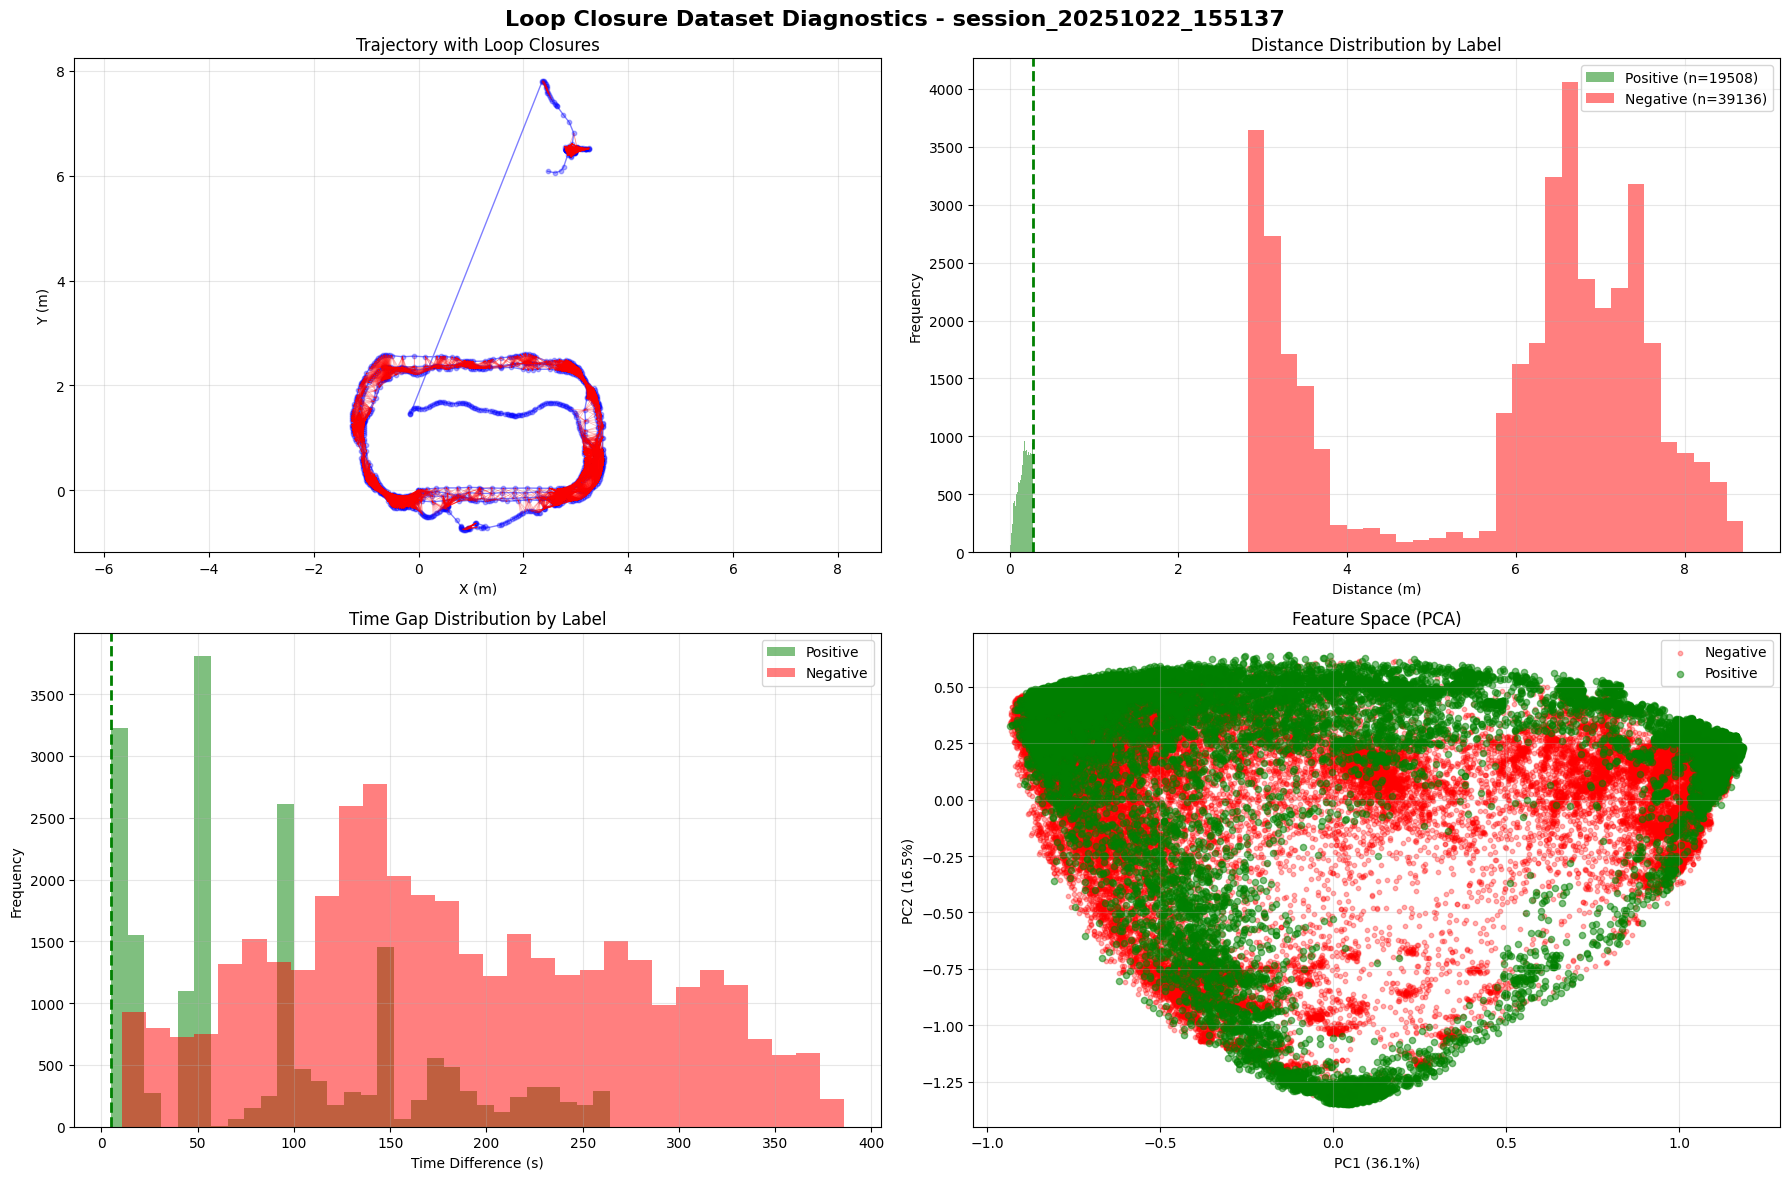

In [12]:
print("\n" + "="*70)
print("DIAGNOSTIC VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'Loop Closure Dataset Diagnostics - {SESSION_ID}', fontsize=16, fontweight='bold')

# Plot 1: Trajectory with loop closures
ax = axes[0, 0]
traj_x = df_trajectory_loaded['x_m'].values
traj_y = df_trajectory_loaded['y_m'].values
ax.plot(traj_x, traj_y, 'b-', alpha=0.5, linewidth=1, label='Trajectory')
ax.scatter(traj_x, traj_y, c='blue', s=10, alpha=0.3)

# Highlight positive pairs
for pair in train_dataset + val_dataset + test_dataset:
    if pair['label'] == 1:
        # Note: pair dict already has node1_id and node2_id from feature assembly
        n1 = df_trajectory_loaded[df_trajectory_loaded['node_id'] == pair['node1_id']].iloc[0]
        n2 = df_trajectory_loaded[df_trajectory_loaded['node_id'] == pair['node2_id']].iloc[0]
        ax.plot([n1['x_m'], n2['x_m']], [n1['y_m'], n2['y_m']], 'r-', alpha=0.3, linewidth=0.5)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Trajectory with Loop Closures')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot 2: Distance distribution by type
ax = axes[0, 1]
pos_distances = [d['distance'] for d in dataset if d['label'] == 1]
neg_distances = [d['distance'] for d in dataset if d['label'] == 0]

ax.hist(pos_distances, bins=30, alpha=0.5, label=f'Positive (n={len(pos_distances)})', color='green')
ax.hist(neg_distances, bins=30, alpha=0.5, label=f'Negative (n={len(neg_distances)})', color='red')
ax.axvline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Frequency')
ax.set_title('Distance Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Time difference distribution
ax = axes[1, 0]
pos_times = [d['time_diff'] for d in dataset if d['label'] == 1]
neg_times = [d['time_diff'] for d in dataset if d['label'] == 0]

ax.hist(pos_times, bins=30, alpha=0.5, label=f'Positive', color='green')
ax.hist(neg_times, bins=30, alpha=0.5, label=f'Negative', color='red')
ax.axvline(POSITIVE_TIME_GAP, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Time Difference (s)')
ax.set_ylabel('Frequency')
ax.set_title('Time Gap Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Feature space (PCA)
ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pos_mask = y == 1
ax.scatter(X_pca[~pos_mask, 0], X_pca[~pos_mask, 1], c='red', alpha=0.3, s=10, label='Negative')
ax.scatter(X_pca[pos_mask, 0], X_pca[pos_mask, 1], c='green', alpha=0.5, s=20, label='Positive')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Feature Space (PCA)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
DIAGNOSTICS_FILE = os.path.join(BASE_PATH, 'dataset', 'dataset_diagnostics.png')
plt.savefig(DIAGNOSTICS_FILE, dpi=150, bbox_inches='tight')
print(f"\n✅ Diagnostic plots saved: {DIAGNOSTICS_FILE}")

plt.show()

## 11. DATASET EXPORT

In [13]:
print("Saving dataset...")

# Package dataset
dataset_package = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset,
    'metadata': {
        'session_id': SESSION_ID,
        'creation_date': str(np.datetime64('today')),
        'num_trajectory_nodes': len(df_trajectory_loaded),
        'num_valid_nodes': len(complete_alignments),
        'num_constraints': len(loop_closure_pairs),
        'feature_dim': X.shape[1],
        'random_seed': RANDOM_SEED,
        'thresholds': {
            'max_time_offset': MAX_TIME_OFFSET,
            'positive_distance_threshold': POSITIVE_DISTANCE_THRESHOLD,
            'positive_time_gap': POSITIVE_TIME_GAP,
            'easy_negative_min_distance': EASY_NEGATIVE_MIN_DISTANCE,
            'hard_negative_min_distance': HARD_NEGATIVE_MIN_DISTANCE,
            'hard_negative_similarity_threshold': HARD_NEGATIVE_SIMILARITY_THRESHOLD,
            'max_constraint_residual': MAX_CONSTRAINT_RESIDUAL,
            'max_angular_distance': MAX_ANGULAR_DISTANCE
        }
    }
}

# Save to pickle
with open(DATASET_FILE, 'wb') as f:
    pickle.dump(dataset_package, f)

file_size_mb = os.path.getsize(DATASET_FILE) / (1024 * 1024)
print(f"\n✅ Dataset saved: {DATASET_FILE}")
print(f"   File size: {file_size_mb:.2f} MB")

Saving dataset...

✅ Dataset saved: dataset/loop_closure_dataset.pkl
   File size: 691.55 MB


### 11.1 Output Usage

This section describes the output file format and how to use the exported dataset.

---

#### 11.1.1 Exported Pickle File Structure

The final output is a pickle file (`loop_closure_dataset.pkl`) containing the complete dataset.

**File Location:**
```
session_YYYYMMDD_HHMMSS/dataset/loop_closure_dataset.pkl
```

**File Format:** Python pickle (binary serialization)  
**Typical Size:** 50-500 MB depending on trajectory length and feature count  
**Compatibility:** Python 3.7+ with numpy, pandas

---

**Internal Dictionary Structure:**

Top-level keys:
- `'train'`: List of training examples
- `'val'`: List of validation examples
- `'test'`: List of test examples
- `'metadata'`: Dictionary with dataset configuration and statistics

**Individual Example Fields:**

Each example in train/val/test contains:
- `'features'`: numpy.ndarray (3072,) float32 - Concatenated multi-modal features
- `'label'`: int (0 or 1) - Binary loop closure label
- `'node1_id'`: int - First trajectory node identifier
- `'node2_id'`: int - Second trajectory node identifier
- `'distance'`: float - Euclidean distance between nodes (meters)
- `'time_diff'`: float - Time difference between nodes (seconds)

**Metadata Fields:**

- `'session_id'`: str - Unique session identifier
- `'creation_date'`: str - Dataset creation date
- `'num_trajectory_nodes'`: int - Total SLAM trajectory nodes
- `'num_valid_nodes'`: int - Nodes with complete feature alignments
- `'num_constraints'`: int - Ground truth loop closure count
- `'feature_dim'`: int - Feature vector dimension (3072)
- `'random_seed'`: int - Random seed for reproducibility
- `'thresholds'`: dict - Configuration parameters (temporal alignment, distance thresholds, similarity thresholds)

**Feature Vector Organization:**

The 3072-dimensional feature vector is organized as:

```
[camera1 (1280) | lidar1 (256) | camera2 (1280) | lidar2 (256)]
[   0:1280      | 1280:1536    |  1536:2816     | 2816:3072    ]
```

- Indices 0-1279: Camera features for node1 (MobileNetV2, L2-normalized)
- Indices 1280-1535: LiDAR features for node1 (1D-CNN, L2-normalized)
- Indices 1536-2815: Camera features for node2 (MobileNetV2, L2-normalized)
- Indices 2816-3071: LiDAR features for node2 (1D-CNN, L2-normalized)

---

#### 11.1.2 Usage Considerations

**Training Pipeline Integration:**
- Pickle file is self-contained and portable
- Can be loaded directly into PyTorch/TensorFlow data loaders
- Features are pre-normalized and ready for network input
- No additional preprocessing required beyond framework-specific tensor conversion

**Compatibility:**
- Python 3.7+ required
- Dependencies: numpy, pandas (for metadata manipulation)
- Pickle protocol: Highest available (optimized for Python 3.8+)
- Cross-platform compatible (Windows/Linux/macOS)

**Storage and Transfer:**
- Pickle files are binary and compressed via pickle protocol
- Additional compression (gzip) can reduce size by ~30-50% if needed
- Files are version-controlled alongside code for reproducibility
- Cloud storage friendly (S3, GCS) for distributed training

**Validation and Quality Checks:**
- Feature dimension consistency validated at save time
- Label distribution statistics computed and stored in metadata
- Split sizes validated against stratification targets
- Referential integrity between node_ids and source data verified

**Limitations:**
- Pickle format is Python-specific (not language-agnostic)
- Large datasets may cause memory pressure when fully loaded
- No incremental/streaming access (entire file must be unpickled)
- Pickle security: Only load files from trusted sources

**Alternative Export Formats:**
While this pipeline uses pickle for convenience, the assembled data could alternatively be exported as:
- HDF5 for language-agnostic access and memory-mapped loading
- TFRecord for TensorFlow pipeline optimization
- Parquet for SQL-queryable feature storage
- NPZ for numpy-native compressed arrays

---

**End of Dataset Documentation**